In [6]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import matplotlib.pyplot as plt
import seaborn as sns
from script.transformer_timestep import *
#plt.style.use('seaborn')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0


2023-02-23 01:42:00.120521: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-23 01:42:00.159429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-02-23 01:42:00.159512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-23 01:42:00.165645: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-23 01:42:00.165761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-23 01:42:00.167306: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

In [7]:
BTC_raw = pd.read_excel('./data/BTC_multi_factor.xlsx')
del BTC_raw['time']
del BTC_raw['symbol']
del BTC_raw['下週期幣種漲跌幅']

In [8]:
#BTC_filtered = BTC_raw.loc[:,list(BTC_raw.columns[0:152])]
#BTC_filtered = BTC_raw
BTC_df = BTC_raw.copy()
BTC_df.head()

,open,high,low,close,volume,quote_volume,trade_num,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,上市天數,漲跌幅,Bias_2,Cmo_2,Atr_2,Cci_2,Volume_2,Psy_2,ZhangDieFu_2,ZhenFu_2,Rsi_2,Ic_2,Bias_3,Cmo_3,Atr_3,Cci_3,Volume_3,Psy_3,ZhangDieFu_3,ZhenFu_3,Rsi_3,Ic_3,Bias_4,Cmo_4,Atr_4,Cci_4,Volume_4,Psy_4,ZhangDieFu_4,ZhenFu_4,Rsi_4,Ic_4,Bias_5,Cmo_5,Atr_5,Cci_5,Volume_5,Psy_5,ZhangDieFu_5,ZhenFu_5,Rsi_5,Ic_5,Bias_6,Cmo_6,Atr_6,Cci_6,Volume_6,Psy_6,ZhangDieFu_6,ZhenFu_6,Rsi_6,Ic_6,Bias_8,Cmo_8,Atr_8,Cci_8,Volume_8,Psy_8,ZhangDieFu_8,ZhenFu_8,Rsi_8,Ic_8,Bias_9,Cmo_9,Atr_9,Cci_9,Volume_9,Psy_9,ZhangDieFu_9,ZhenFu_9,Rsi_9,Ic_9,Bias_12,Cmo_12,Atr_12,Cci_12,Volume_12,Psy_12,ZhangDieFu_12,ZhenFu_12,Rsi_12,Ic_12,Bias_13,Cmo_13,Atr_13,Cci_13,Volume_13,Psy_13,ZhangDieFu_13,ZhenFu_13,Rsi_13,Ic_13,Bias_21,Cmo_21,Atr_21,Cci_21,Volume_21,Psy_21,ZhangDieFu_21,ZhenFu_21,Rsi_21,Ic_21,Bias_24,Cmo_24,Atr_24,Cci_24,Volume_24,Psy_24,ZhangDieFu_24,ZhenFu_24,Rsi_24,Ic_24,Bias_30,Cmo_30,Atr_30,Cci_30,Volume_30,Psy_30,ZhangDieFu_30,ZhenFu_30,Rsi_30,Ic_30,Bias_34,Cmo_34,Atr_34,Cci_34,Volume_34,Psy_34,ZhangDieFu_34,ZhenFu_34,Rsi_34,Ic_34,Bias_36,Cmo_36,Atr_36,Cci_36,Volume_36,Psy_36,ZhangDieFu_36,ZhenFu_36,Rsi_36,Ic_36,Bias_48,Cmo_48,Atr_48,Cci_48,Volume_48,Psy_48,ZhangDieFu_48,ZhenFu_48,Rsi_48,Ic_48,Bias_55,Cmo_55,Atr_55,Cci_55,Volume_55,Psy_55,ZhangDieFu_55,ZhenFu_55,Rsi_55,Ic_55,Bias_60,Cmo_60,Atr_60,Cci_60,Volume_60,Psy_60,ZhangDieFu_60,ZhenFu_60,Rsi_60,Ic_60,Bias_64,Cmo_64,Atr_64,Cci_64,Volume_64,Psy_64,ZhangDieFu_64,ZhenFu_64,Rsi_64,Ic_64,Bias_72,Cmo_72,Atr_72,Cci_72,Volume_72,Psy_72,ZhangDieFu_72,ZhenFu_72,Rsi_72,Ic_72,Bias_89,Cmo_89,Atr_89,Cci_89,Volume_89,Psy_89,ZhangDieFu_89,ZhenFu_89,Rsi_89,Ic_89,Bias_96,Cmo_96,Atr_96,Cci_96,Volume_96,Psy_96,ZhangDieFu_96,ZhenFu_96,Rsi_96,Ic_96
0,10000.00,10412.65,10000.00,10391.63,3096.291,3.209630e+07,3754,0.039,4.033562e+02,1,0.039163,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.0,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.0000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.0
1,10391.63,10391.63,10092.71,10149.47,3444.238,3.539813e+07,4020,0.001,1.030921e+01,1,-0.023303,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0.000000,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.0,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0.000000,NaN,0.041265,0.000000,1.0,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0.0,NaN,0.041265,0.000000,1.0,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0.0000

In [19]:
BTC_df.columns[11:-1]

Index(['Bias_2', 'Cmo_2', 'Atr_2', 'Cci_2', 'Volume_2', 'Psy_2',
       'ZhangDieFu_2', 'ZhenFu_2', 'Rsi_2', 'Ic_2',
       ...
       'Ic_89', 'Bias_96', 'Cmo_96', 'Atr_96', 'Cci_96', 'Volume_96', 'Psy_96',
       'ZhangDieFu_96', 'ZhenFu_96', 'Rsi_96'],
      dtype='object', length=209)

In [20]:
print ("Shape Of The Before Ouliers: ",BTC_df.shape)
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(BTC_df['close'],75) - np.percentile(BTC_df['close'],25)
#outlier = Q3 + n*IQR 
BTC_df=BTC_df[BTC_df['close'] < np.percentile(BTC_df['close'],75)+n*IQR]
#outlier = Q1 - n*IQR 
BTC_df=BTC_df[BTC_df['close'] > np.percentile(BTC_df['close'],25)-n*IQR]
print ("Shape Of The After Ouliers: ",BTC_df.shape)

Shape Of The Before Ouliers:  (3421, 221)
Shape Of The After Ouliers:  (3421, 221)


In [21]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [34]:
BTC_df.dropna(how='any', axis=0, inplace=True)
times = sorted(BTC_df.index.values)
last_10pct = sorted(BTC_df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(BTC_df.index.values)[-int(0.2*len(times))] # Last 20% of series

In [35]:
# Min-max normalize price columns (0-1 range)
BTC_df[['open', 'high', 'low', 'close','volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume']] = BTC_df[['open', 'high', 'low', 'close','volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume']].rolling(10).mean()
BTC_df['open']   = BTC_df['open'].pct_change() # Create arithmetic returns column
BTC_df['high']   = BTC_df['high'].pct_change() # Create arithmetic returns column
BTC_df['low']    = BTC_df['low'].pct_change() # Create arithmetic returns column
BTC_df['close']  = BTC_df['close'].pct_change() # Create arithmetic returns column
BTC_df['volume'] = BTC_df['volume'].pct_change()
BTC_df['taker_buy_base_asset_volume']  = BTC_df['taker_buy_base_asset_volume'].pct_change()
BTC_df['taker_buy_quote_asset_volume'] = BTC_df['taker_buy_quote_asset_volume'].pct_change()

BTC_df.dropna(how='any', axis=0, inplace=True)

min_return = min(BTC_df[(BTC_df.index < last_10pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(BTC_df[(BTC_df.index < last_10pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
BTC_df['open'] = (BTC_df['open'] - min_return) / (max_return - min_return)
BTC_df['high'] = (BTC_df['high'] - min_return) / (max_return - min_return)
BTC_df['low'] = (BTC_df['low'] - min_return) / (max_return - min_return)
BTC_df['close'] = (BTC_df['close'] - min_return) / (max_return - min_return)
# close_scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['open', 'high', 'low', 'close']])
# BTC_df[['open', 'high', 'low', 'close']]  = close_scaler.transform(BTC_df[['open', 'high', 'low', 'close']] )



# # Min-max volume column
vol_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['volume']].min(axis=0))
vol_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['volume']].max(axis=0))
BTC_df['volume'] = (BTC_df['volume'] - vol_min_return) / (vol_max_return - vol_min_return)

# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['volume']])
# BTC_df[['volume']] = scaler.transform(BTC_df[['volume']])


# # Min-max quote_volume column
quote_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['quote_volume']].min(axis=0))
quote_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['quote_volume']].max(axis=0))
BTC_df['quote_volume'] = (BTC_df['quote_volume'] - quote_volume_min_return) / (quote_volume_max_return - quote_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['quote_volume']])
# BTC_df[['quote_volume']] = scaler.transform(BTC_df[['quote_volume']])


# # # Min-max taker_buy_base_asset_volume column
taker_buy_base_asset_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_base_asset_volume']].min(axis=0))
taker_buy_base_asset_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_base_asset_volume']].max(axis=0))
BTC_df['taker_buy_base_asset_volume'] = (BTC_df['taker_buy_base_asset_volume'] - taker_buy_base_asset_volume_min_return) / (taker_buy_base_asset_volume_max_return - taker_buy_base_asset_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['taker_buy_base_asset_volume']])
# BTC_df[['taker_buy_base_asset_volume']] = scaler.transform(BTC_df[['taker_buy_base_asset_volume']])

# # # Min-max taker_buy_quote_asset_volume column
taker_buy_quote_asset_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_quote_asset_volume']].min(axis=0))
taker_buy_quote_asset_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_quote_asset_volume']].max(axis=0))
BTC_df['taker_buy_quote_asset_volume'] = (BTC_df['taker_buy_base_asset_volume'] - taker_buy_quote_asset_volume_min_return) / (taker_buy_quote_asset_volume_max_return - taker_buy_quote_asset_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['taker_buy_quote_asset_volume']])
# BTC_df[['taker_buy_quote_asset_volume']] = scaler.transform(BTC_df[['taker_buy_quote_asset_volume']])

# # # Min-max trade_num column
trade_num_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['trade_num']].min(axis=0))
trade_num_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['trade_num']].max(axis=0))
BTC_df['trade_num'] = (BTC_df['trade_num'] - trade_num_min_return) / (trade_num_max_return - trade_num_min_return)

# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['trade_num']])
# BTC_df[['trade_num']] = scaler.transform(BTC_df[['trade_num']])

# 
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][BTC_df.columns[11:-1]])
# BTC_df[BTC_df.columns[11:-1]] = scaler.transform(BTC_df[BTC_df.columns[11:-1]])

In [24]:

df_train = BTC_df[(BTC_df.index < last_10pct)]  # Training data are 80% of total data
df_val   = BTC_df[(BTC_df.index >= last_20pct) & (BTC_df.index < last_10pct)]
df_test  = BTC_df[(BTC_df.index >= last_10pct)]

In [36]:
BTC_df.head()

,open,high,low,close,volume,quote_volume,trade_num,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,上市天數,漲跌幅,Bias_2,Cmo_2,Atr_2,Cci_2,Volume_2,Psy_2,ZhangDieFu_2,ZhenFu_2,Rsi_2,Ic_2,Bias_3,Cmo_3,Atr_3,Cci_3,Volume_3,Psy_3,ZhangDieFu_3,ZhenFu_3,Rsi_3,Ic_3,Bias_4,Cmo_4,Atr_4,Cci_4,Volume_4,Psy_4,ZhangDieFu_4,ZhenFu_4,Rsi_4,Ic_4,Bias_5,Cmo_5,Atr_5,Cci_5,Volume_5,Psy_5,ZhangDieFu_5,ZhenFu_5,Rsi_5,Ic_5,Bias_6,Cmo_6,Atr_6,Cci_6,Volume_6,Psy_6,ZhangDieFu_6,ZhenFu_6,Rsi_6,Ic_6,Bias_8,Cmo_8,Atr_8,Cci_8,Volume_8,Psy_8,ZhangDieFu_8,ZhenFu_8,Rsi_8,Ic_8,Bias_9,Cmo_9,Atr_9,Cci_9,Volume_9,Psy_9,ZhangDieFu_9,ZhenFu_9,Rsi_9,Ic_9,Bias_12,Cmo_12,Atr_12,Cci_12,Volume_12,Psy_12,ZhangDieFu_12,ZhenFu_12,Rsi_12,Ic_12,Bias_13,Cmo_13,Atr_13,Cci_13,Volume_13,Psy_13,ZhangDieFu_13,ZhenFu_13,Rsi_13,Ic_13,Bias_21,Cmo_21,Atr_21,Cci_21,Volume_21,Psy_21,ZhangDieFu_21,ZhenFu_21,Rsi_21,Ic_21,Bias_24,Cmo_24,Atr_24,Cci_24,Volume_24,Psy_24,ZhangDieFu_24,ZhenFu_24,Rsi_24,Ic_24,Bias_30,Cmo_30,Atr_30,Cci_30,Volume_30,Psy_30,ZhangDieFu_30,ZhenFu_30,Rsi_30,Ic_30,Bias_34,Cmo_34,Atr_34,Cci_34,Volume_34,Psy_34,ZhangDieFu_34,ZhenFu_34,Rsi_34,Ic_34,Bias_36,Cmo_36,Atr_36,Cci_36,Volume_36,Psy_36,ZhangDieFu_36,ZhenFu_36,Rsi_36,Ic_36,Bias_48,Cmo_48,Atr_48,Cci_48,Volume_48,Psy_48,ZhangDieFu_48,ZhenFu_48,Rsi_48,Ic_48,Bias_55,Cmo_55,Atr_55,Cci_55,Volume_55,Psy_55,ZhangDieFu_55,ZhenFu_55,Rsi_55,Ic_55,Bias_60,Cmo_60,Atr_60,Cci_60,Volume_60,Psy_60,ZhangDieFu_60,ZhenFu_60,Rsi_60,Ic_60,Bias_64,Cmo_64,Atr_64,Cci_64,Volume_64,Psy_64,ZhangDieFu_64,ZhenFu_64,Rsi_64,Ic_64,Bias_72,Cmo_72,Atr_72,Cci_72,Volume_72,Psy_72,ZhangDieFu_72,ZhenFu_72,Rsi_72,Ic_72,Bias_89,Cmo_89,Atr_89,Cci_89,Volume_89,Psy_89,ZhangDieFu_89,ZhenFu_89,Rsi_89,Ic_89,Bias_96,Cmo_96,Atr_96,Cci_96,Volume_96,Psy_96,ZhangDieFu_96,ZhenFu_96,Rsi_96,Ic_96
106,0.524752,0.525455,0.527104,0.525567,0.388190,0.000784,0.000551,0.399462,0.887932,36,0.003365,0.001660,-64.328320,0.024384,2.224757,0.354335,50,-0.011810,0.039165,43.372306,0.980384,-0.002871,-7.275575,0.021144,-45.605468,0.243735,33.333333,-0.002066,0.039165,43.035458,0.982324,-0.002670,0.763478,0.018345,-56.786518,0.198266,25,0.000235,0.039165,43.462420,1.012769,-0.002090,-20.562998,0.017196,-63.021881,0.159636,20,-0.007961,0.039165,44.351822,1.012769,-0.003073,-9.589810,0.016481,-64.111951,0.134419,16.666667,-0.004100,0.039165,45.421620,1.011759,-0.002121,-7.430015,0.016394,-22.454708,0.100639,12.5,-0.004655,0.039165,47.322207,1.004464,-0.002403,-14.657682,0.016145,-22.831470,0.086326,11.111111,-0.009909,0.039165,48.010634,1.004972,-0.007480,-37.117537,0.019622,-51.521998,0.055670,8.333333,-0.035895,0.079965,49.043349,0.933087,-0.009725,-29.131703,0.019404,-49.121659,0.052219,7.692308,-0.030094,0.079965,49.119850,0.928149,-0.004838,26.527931,0.022313,-22.640062,0.029887,4.761905,0.055987,0.117782,47.799158,0.944068,0.001750,18.598942,0.022545,2.862048,0.026864,4.166667,0.043223,0.132474,47.094771,0.948626,0.006577,8.216716,0.021138,20.846301,0.023418,3.333333,0.021603,0.132474,45.860737,0.953682,0.007590,-1.926911,0.021717,18.732638,0.021334,2.941176,-0.005983,0.132474,45.197360,0.954511,0.007239,3.913279,0.021458,15.001909,0.020519,2.777778,0.013137,0.132474,44.909217,0.955210,0.009665,2.051188,0.024005,7.631401,0.015677,2.083333,0.011010,0.139965,43.638593,0.953808,0.011393,-2.380873,0.025598,6.852473,0.013641,1.818182,-0.015172,0.141199,43.147558,0.953578,0.007245,-20.850188,0.030360,3.334768,0.011835,1.666667,-0.148990,0.268461,42.869173,0.980537,-0.004566,-23.426106,0.029779,-3.682223,0.011272,1.5625,-0.171691,0.304680,42.679473,0.988209,-0.026868,-24.161637,0.027840,-17.386703,0.010448,1.388889,-0.182572,0.329260,42.367511,0.993416,-0.061666,-23.087618,0.025503,-43.890930,0.009105,1.123596,-0.198478,0.353125,41.904432,0.998471,-0.073020,-18.712803,0.024792,-54.822522,0.008713,1.041667,-0.176287,0.357042,41.765554,0.999301
107,0.525449,0.501286,0.544271,0.539435,0.236018,0.002112,0.001687,0.237636,0.689185,36,-0.006098,-0.003061,-29.623945,0.009957,-33.289201,0

In [25]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2983, 221)
Validation data shape: (333, 221)
Test data shape: (332, 221)


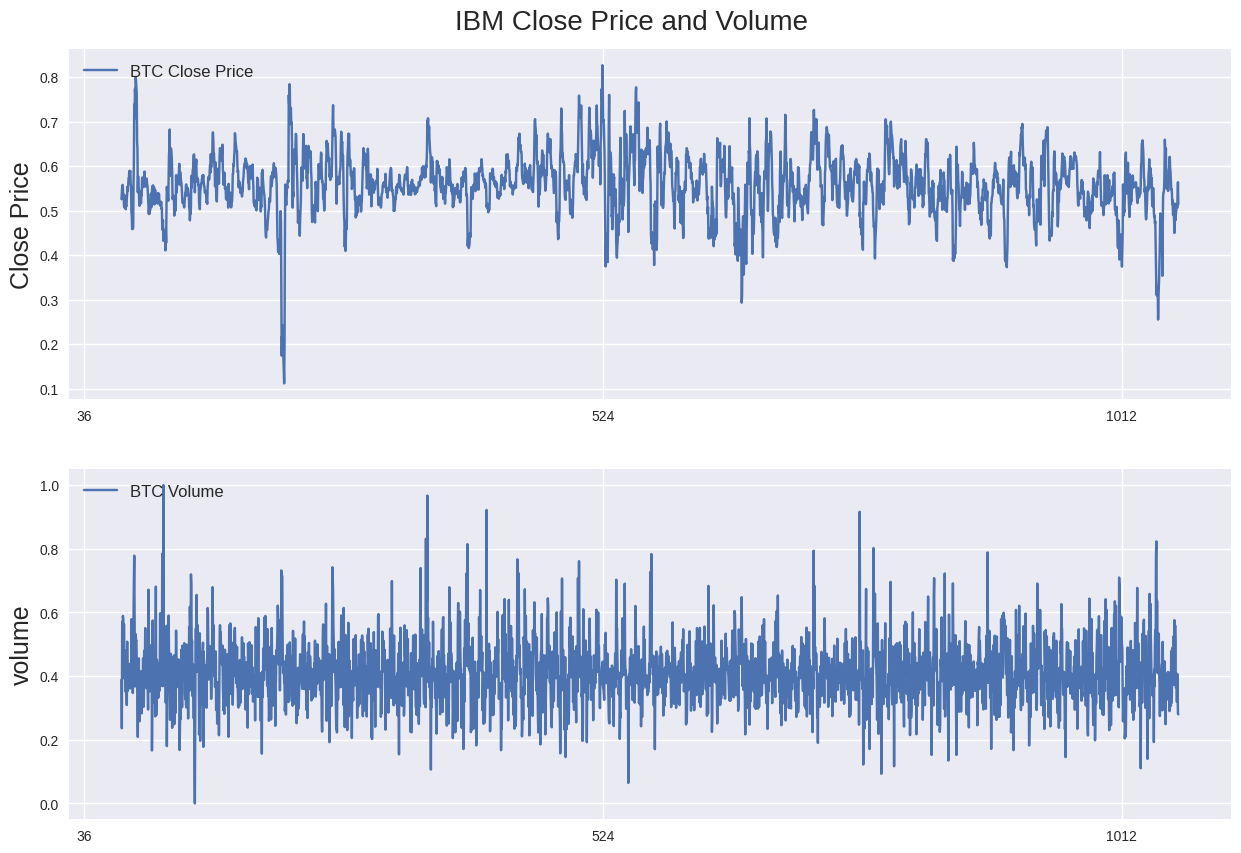

In [26]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df_train['close'], label='BTC Close Price')
ax1.set_xticks(range(0, df_train.shape[0], 1464))
ax1.set_xticklabels(df_train['上市天數'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df_train['volume'], label='BTC Volume')
ax2.set_xticks(range(0, df_train.shape[0], 1464))
ax2.set_xticklabels(df_train['上市天數'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [27]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# ###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2855, 128, 221) (2855,)
(205, 128, 221) (205,)
(204, 128, 221) (204,)


In [28]:
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_ft221.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 221)]   0                                            
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 128, 2)       512         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 223)     0           input_2[0][0]                    
                                                                 time2_vector_2[0][0]             
__________________________________________________________________________________________________
transformer_encoder_6 (Transfor (None, 128, 223)     2865210     concatenate_1[0][0]        

In [29]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))


Epoch 1/35
90/90 [==============================] - 88s 719ms/step - loss: 0.0376 - mae: 0.1260 - mape: 23.1174 - val_loss: 0.0077 - val_mae: 0.0631 - val_mape: 14.3989

Epoch 00001: val_loss improved from inf to 0.00774, saving model to ./model_weight/transformer_btc_multi_factor_ft221.hdf5
Epoch 2/35
90/90 [==============================] - 59s 652ms/step - loss: 0.0065 - mae: 0.0617 - mape: 11.8607 - val_loss: 0.0064 - val_mae: 0.0558 - val_mape: 12.7395

Epoch 00002: val_loss improved from 0.00774 to 0.00643, saving model to ./model_weight/transformer_btc_multi_factor_ft221.hdf5
Epoch 3/35
90/90 [==============================] - 58s 650ms/step - loss: 0.0065 - mae: 0.0614 - mape: 11.8091 - val_loss: 0.0068 - val_mae: 0.0583 - val_mape: 13.3029

Epoch 00003: val_loss did not improve from 0.00643
Epoch 4/35
90/90 [==============================] - 58s 649ms/step - loss: 0.0062 - mae: 0.0607 - mape: 11.6412 - val_loss: 0.0058 - val_mae: 0.0528 - val_mape: 11.9918

Epoch 00004: val_lo

In [30]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_ft221.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred   = model.predict(X_val)
test_pred  = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval   = model.evaluate(X_val, y_val, verbose=0)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0007, MAE: 0.0197, MAPE: 3.6268
Validation Data - Loss: 0.0005, MAE: 0.0174, MAPE: 3.5183
Test Data - Loss: 0.0008, MAE: 0.0205, MAPE: 3.7768


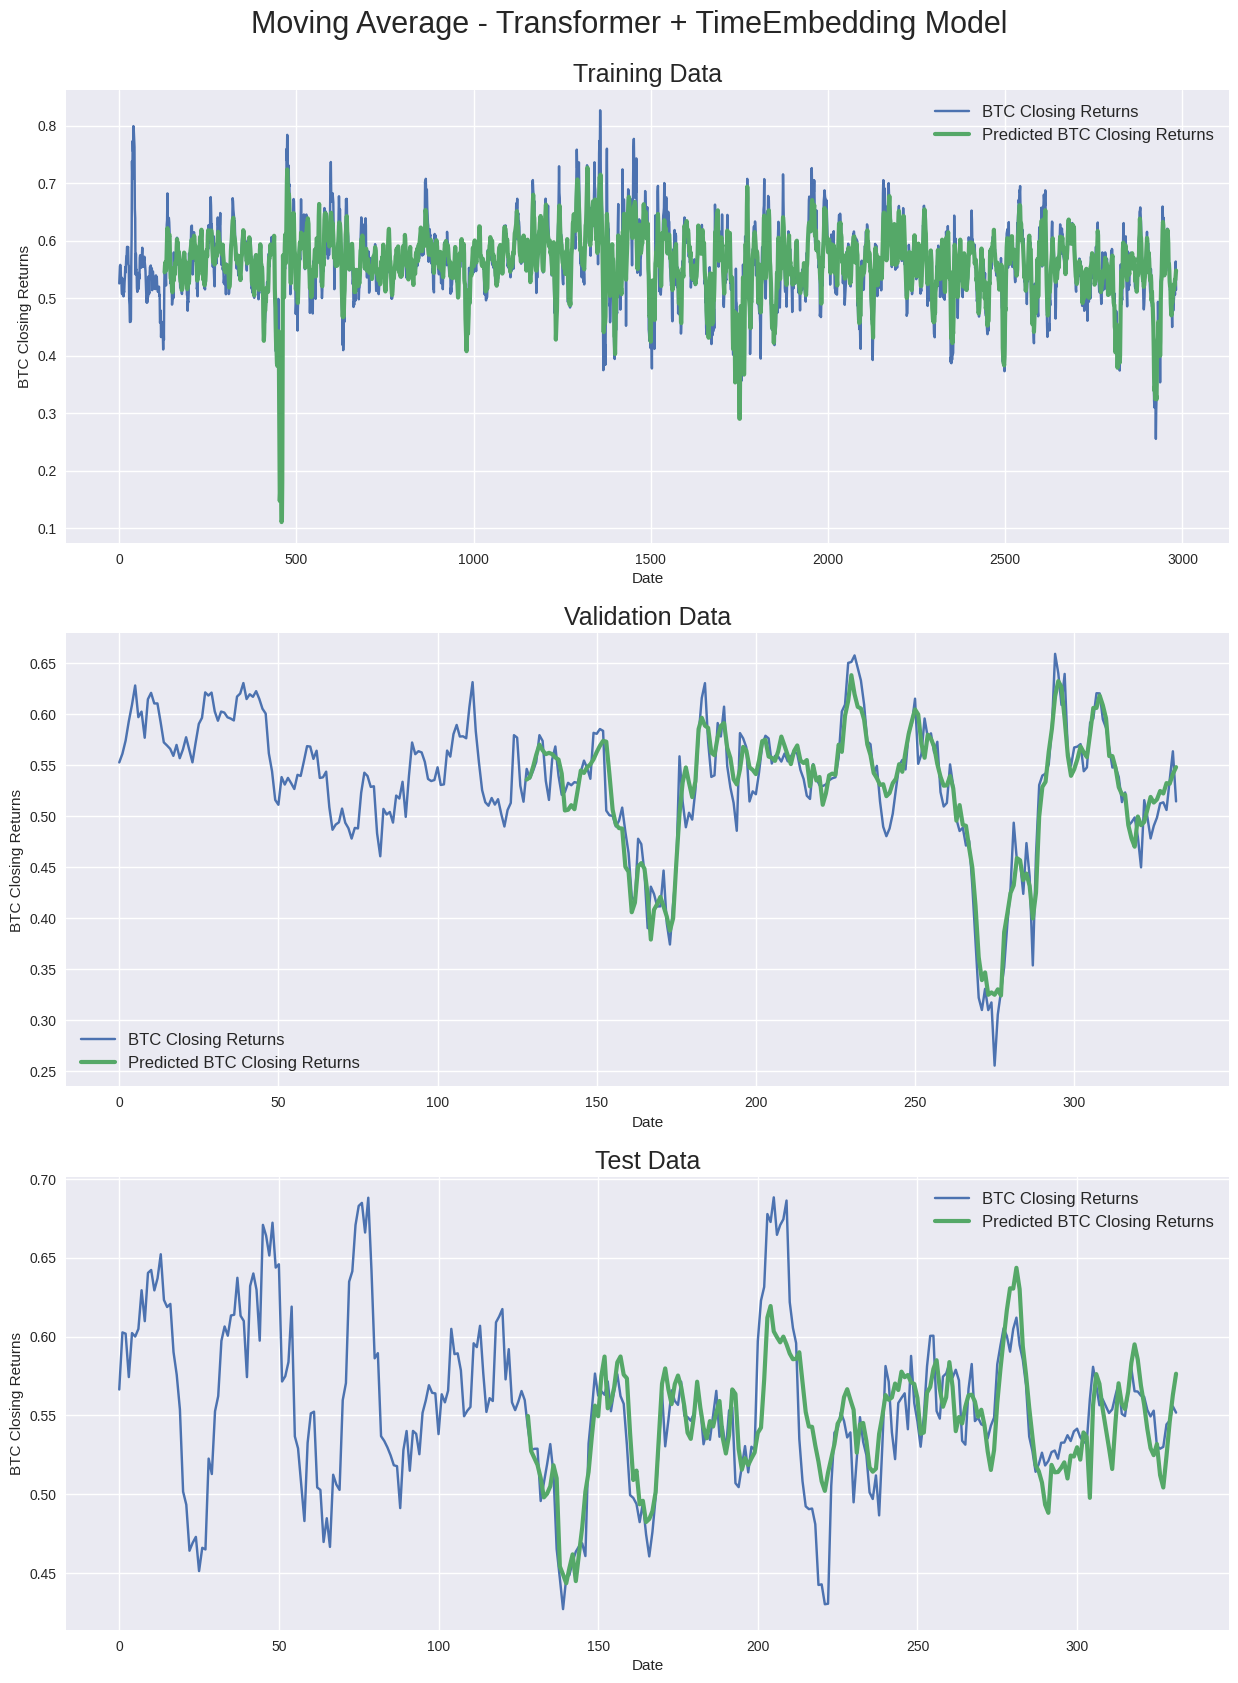

In [31]:

#'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='BTC Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='BTC Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='BTC Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
y_train[:10]

In [ ]:
btc_corr.style.background_gradient(cmap='Blues')